<h3>Very simple Neural Network. 
    A Conv1D layer is trained with an embedding layer. 
    Then a residual block finishes the job !

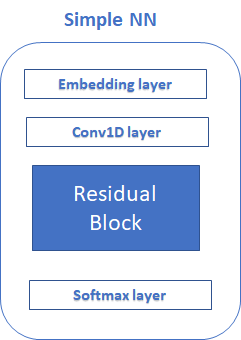

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss

import gc

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

from keras.models import Model


In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission = submission.set_index('id')


In [ ]:
targets = pd.get_dummies(train['target'])

In [ ]:
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

cce = tf.keras.losses.CategoricalCrossentropy()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric', min_delta=1e-05, patience=5, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric', factor=0.7, patience=2, verbose=0,
    mode='min')

In [ ]:
def conv_model():

    conv_inputs = layers.Input(shape = (75))
    #----------- Embedding layers ----------------------
    embed = layers.Embedding (input_dim = 354, 
                              output_dim = 7,
                              embeddings_regularizer='l2')(conv_inputs)
    #----------- Convolution layers ----------------------
    embed = layers.Conv1D(12,1,activation = 'relu')(embed)        
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    
    #----------- Residual blocks layers ----------------------
    hidden = tfa.layers.WeightNormalization(
                layers.Dense(
                units=32,
                activation ='selu',
                kernel_initializer = "lecun_normal"))(hidden)
    
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(
    layers.Dense(
                units = 32,
                activation='relu',
                kernel_initializer = "lecun_normal"))(output) 
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, output]))
    output = tfa.layers.WeightNormalization(
    layers.Dense(
                units = 32, 
                activation = 'elu',
                kernel_initializer = "lecun_normal"))(output)
    
    #----------- Final layer -----------------------
    conv_outputs = layers.Dense(
                units = 9, 
                activation ='softmax',
                kernel_initializer ="lecun_normal")(output)
    
    #----------- Model instantiation  ---------------
    model = Model(conv_inputs,conv_outputs)
    
    return model

In [ ]:
oof_NN_a = np.zeros((train.shape[0],9))
pred_NN_a = np.zeros((test.shape[0],9))

N_FOLDS = 25
SEED = 2021
EPOCH = 70


skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, ts_idx) in enumerate(skf.split(train,train.iloc[:,-1])):
    print(f"\n ====== TRAINING FOLD {fold} =======\n")

    X_train = train.iloc[:,1:-1].iloc[tr_idx]
    y_train = targets.iloc[tr_idx]
    X_test = train.iloc[:,1:-1].iloc[ts_idx]
    y_test = targets.iloc[ts_idx]

    K.clear_session()

    #================= NN CONV MODEL training =========
    
    print("\n-----Convolution model Training----\n")

    model_conv = conv_model()

    model_conv.compile(loss='categorical_crossentropy', 
                            optimizer = keras.optimizers.Adam(learning_rate=2e-4), 
                            metrics=custom_metric)
    model_conv.fit(X_train, y_train,
              batch_size = 256, epochs = EPOCH,
              validation_data=(X_test, y_test),
              callbacks=[es, plateau],
              verbose = 0)
   
    #============== Convolution Model prediction ==========

    pred_a = model_conv.predict(X_test) 
    oof_NN_a[ts_idx] += pred_a 
    score_NN_a = log_loss(y_test, pred_a)
    print(f"\nFOLD {fold} Score convolution model: {score_NN_a}\n")
    pred_NN_a += model_conv.predict(test.iloc[:,1:]) / N_FOLDS 
 
score_a = log_loss(targets, oof_NN_a)
print(f"\n=== FINAL SCORE CONVOLUTION MODEL : {score_a}===\n") 

In [ ]:
pred_embedding = pred_NN_a

In [ ]:
submission = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission['Class_1']=pred_embedding[:,0]
submission['Class_2']=pred_embedding[:,1]
submission['Class_3']=pred_embedding[:,2]
submission['Class_4']=pred_embedding[:,3]
submission['Class_5']=pred_embedding[:,4]
submission['Class_6']=pred_embedding[:,5]
submission['Class_7']=pred_embedding[:,6]
submission['Class_8']=pred_embedding[:,7]
submission['Class_9']=pred_embedding[:,8]

In [ ]:
submission.to_csv("Keras_9.csv", index=False)